# Data Processing and Cleaning

In [6]:
import os
import json
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn import metrics
import math
from transformers import pipeline
import torch
import ollama
import csv
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# directory = '.\\goodreads' # directory where the json files were stored

### Joining of the data with equally distribution of genders and ratings
- We left the directory out of submition to save space only left the code for example and the output file
- The output of the below code yield the `filtered_data_equalRating_dist.csv` that was then used to train and evaluate the models

In [ ]:
# order = ['children', 'comics_graphics', 'fantasy_paranormal', 'history_biography', 'mystery_thriller_crime', 'poetry', 'romance', 'young_adult']
# final_df = pd.DataFrame()

# index = -1
# for filename in os.listdir(directory):
#     if filename.endswith('.json'):
#         index+=1
#         filename = os.path.join(directory, filename)
#         with open(filename, 'r') as file:
#             counter = 0
#             counterR0 = 0
#             counterR1 = 0
#             counterR2 = 0
#             counterR3 = 0
#             counterR4 = 0
#             counterR5 = 0
#             jsonData = []
#             for line in file:
#                 json_line = json.loads(line)
#                 rating = json_line["rating"]
                
#                 if int(rating) == 0 and counterR0 <= counter / 6:
#                     counterR0 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 1 and counterR1 <= counter / 6:
#                     counterR1 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 2 and counterR2 <= counter / 6:
#                     counterR2 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 3 and counterR3 <= counter / 6:
#                     counterR3 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 4 and counterR4 <= counter / 6:
#                     counterR4 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 5 and counterR5 <= counter / 6:
#                     counterR5 += 1
#                     jsonData.append(json_line)
                    
#                 counter = counterR0 + counterR1 + counterR2 + counterR3 + counterR4 + counterR5 
#                 print(counter)
#                 if (counter) == 5000:
#                     break
                
#             jsonDataFrame = pd.DataFrame(jsonData)
#             jsonDataFrame["type"] = order[index]
#             final_df = pd.concat([final_df, jsonDataFrame], axis=0)
# final_df.to_csv('filtered_data_equalRating_dist.csv', index=False)

# Using ollama, ollama-python and Llhama 3.2 model to predict ratings
- To be able to run the Llama 3.2 with Ollama, the user should have the following installed:
    - Download and install [Ollama](https://ollama.com/download)
    - Install the Llama 3.2 model using `ollama run llama3.2`
    - Make sure Ollama is up and running and also have installed [ollama-python](https://github.com/ollama/ollama-python) with `pip install ollama`

In [2]:
df = pd.read_csv('filtered_data_equalRating_dist.csv')
df.drop(columns=["user_id", "review_id", "book_id"], inplace=True) # drop columns that are not needed
df = df.dropna(subset=['review_text']) # drop rows with missing values
df["review_text"] = df["review_text"].astype(str)

### Prompt used Inspired by [Text Classification with Large Language Models (LLMs)](https://hussainpoonawala.medium.com/text-classification-with-large-language-models-llms-a23c731a687e) by Hussain Poonawala.

### Sampled into 1500 of each rating

In [ ]:
# Split the dataframe into 5 for each rating with 20 of each
# dfs = []
# for rating in range(0, 6):
#     dfs.append(df[df['rating'] == rating].sample(n=1500, random_state=1))
# df_sampled = pd.concat(dfs).reset_index(drop=True)

### Using the prompt for rating prediction
- It as fail safe assertions for non-blocking code
- The prompt consists of asking for Llhama 3.2 to output a json with format:
{{
"predictedRating": "",
"auditReasons": [],
"reason": ""
}}
- The prompt also has a `multiple shot approach` which allow the model to reason better about the response it should yield
- The json data is the parsed and saved in real time to the `predicted_ratings.csv` to allow multiple runs

In [ ]:
i = 0
n_trues = 0
n_falses = 0

df_sampled = pd.read_csv('sampled_data.csv')
# Open a CSV file to write the JSON output
with open('predicted_ratings.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Real Rating', 'Predicted Rating', 'Assertion', 'Audit Reasons', 'Iteration', 'StartTime', 'EndTime', 'Duration'])

    while i <= 9000:
        # Record the start time
        start_time = time.time()
        review_text = df_sampled.iloc[i]['review_text']
        
        prompt = f"""
            You are tasked with classifying a book review based on a human's rating on a scale of 0 to 5, reflecting their overall satisfaction with the book. The review is the following: "{review_text}".
            The review was posted on an online book reviewing platform. Use the following criteria to guide your classification:
            **Rating Scale**:
            1. 0 - Really Bad
            1. 1 - Very Bad
            2. 2 - Bad
            3. 3 - Average
            4. 4 - Good
            5. 5 - Very Good

            **Guidelines**:
            1. Read the review carefully, paying attention to both the explicit content and implied sentiments.
            2. Think like a human reviewer and infer the overall impression and satisfaction level of the user from the text.
            3. Avoid simple keyword matching or sentiment analysis. Instead, consider the deeper meaning and tone of the review.
            
            **Key Aspects to Consider**:
            - **Sentiment**: Is the overall tone positive, negative, or neutral?
            - **Engagement**: Does the reviewer seem deeply involved with the book or detached and indifferent?
            - **Plot and Character Satisfaction**: Are there complaints about the plot or characters that indicate dissatisfaction, or praise that suggests satisfaction?
            - **Recommendation Willingness**: Does the reviewer express a desire to recommend the book to others, or show reluctance?

            **Audit Reason Categories**:
            You must select one reason that justifies your classification, using the following categories:
            1. Positive Sentiment
            2. Negative Sentiment
            3. Neutral Sentiment
            4. Plot Dissatisfaction
            5. Character Dissatisfaction
            6. Lack of Engagement
            7. Recommendation Hesitation
            8. Pacing Issues
            9. Repetition (Feeling of Deja Vu)
            10. General Enjoyment

            **DOs**:
            1. Be specific and clear in your audit reasoning.
            2. Think like a human reviewer, understanding the overall impression, tone, and the context of the book being reviewed.
            3. Consider nuanced factors like pacing, emotional engagement, and depth of plot/character development.
            4. Use the Output Format provided below to structure your response.
            
            **DON'Ts**:
            1. Do not rely purely on word choices for classification.
            2. Avoid guesses or assumptions. Base your classification solely on the review content provided.
            3. Do not repeat the same audit reasons unless strongly justified by the review.
            4. Do not add any additional information before or after the Output Format, i really just want to see the json output.
            5. Do not include any extra characters in the output.

            **Output Format**:
            {{
            "predictedRating": "",
            "auditReasons": [],
            "reason": ""
            }}

            Examples:

            1. Review: 'One of my favorite books to read to my 5-year-old. Beautifully written and keeps them engaged the whole time.'
            Output: {{ predictedRating: "5", auditReasons: ['Positive Sentiment'], "reason": "The reviewer expresses clear satisfaction." }}

            2. Review: 'Fun sequel to the original, but not quite as captivating.'
            Output: {{ predictedRating: "4", auditReasons: ['Positive Sentiment'], "reason": "Generally positive but less engaging." }}

            3. Review: 'I'm getting bored... it's the same book, over and over again. But now I'm invested in finding out what happens to these children.'
            Output: {{ predictedRating: "2", auditReasons: ['Negative Sentiment'], "reason": "Dissatisfaction with repetition." }}

            4. Review: 'The characters were well-written, but the pacing was just too slow. Took me a long time to finish.'
            Output: {{ predictedRating: "3", auditReasons: ['Neutral Sentiment'], "reason": "Mixed feelings about pacing." }}

            5. Review: 'I wanted to love it, but the plot was too predictable. I wouldn't recommend it to others.'
            Output: {{ predictedRating: "2", auditReasons: ['Negative Sentiment'], "reason": "Disappointment with predictable plot." }}
            
            6. Review: 'Huh, loppuipa vihdoin. Lopun paljastus siita, etta Narnia onkin taivas, ei ollut todellakaan mikaan yllatys. Kokonaisuudessaan Narnia ei tosiaan ole kirjasarja omaan makuuni ja luulen, etta jos olisin lukenut kirjat nuorempana, olisi suhtautuminen varmaan toinen. Nyt, ateistina, liian paalleliimattu kristillisyys arsytti, samoin Aslanin hahmo. Aikarakenteen muuttuminen kirjasta toiseen oli vahan omituinen ratkaisu, tosin kirjat olisi voinut myos lukea kronologisessa jarjestyksessa... Juonet kirjoissa olivat aika suoraviivaisia (ehka viimeista kirjaa lukuunottamatta) ja satumaisia, hahmot yksiulotteisia ja aika yhdentekevia. Maailman kuvaus toimi hyvin, mutta motiivien ja syiden kertominen ei. Aika yhdentekevia kirjoja minulle.'
            Output: {{ predictedRating: "1", auditReasons: ['Negative Sentiment'], "reason": "Strong dissatisfaction with plot and characters." }}
            
            7. Review: 'I really don't like this book. It makes it seem like the baby's interactions are almost exclusively through social media. Plus, the illustrations are not very inspiring.'
            Output: {{ predictedRating: "1", auditReasons: ['Negative Sentiment'], "reason": "Strong dissatisfaction with plot and characters." }}
            
            Please follow the guidelines strictly and classify based on the full context of the review.
            """
        response = ollama.generate(model='llama3.2:latest', prompt=prompt, format="json", options=ollama.Options(timeout=360000))["response"]
        # Parse the response into JSON string
        try:
            parsed_json_response = json.loads(response)
        except json.JSONDecodeError as e:
            continue
        # Accessing the parsed JSON data
        predicted_rating = parsed_json_response["predictedRating"]
        audit_reasons = parsed_json_response["auditReasons"]
        # reason = parsed_json_response["reason"]
        real_rating = df_sampled.iloc[i]['rating']
        try:
            assertion = real_rating == int(predicted_rating)
        except ValueError as e:
            print(f"Error converting predicted rating to int: {e}")
            continue
        print(f"Real Rating: {real_rating}, Predicted Rating: {predicted_rating}, Assertion: {assertion}")
        
        # Record the end time
        end_time = time.time()
        duration = end_time - start_time
        
        n_trues += 1 if assertion else 0
        n_falses += 1 if not assertion else 0
        
        print("Percentage of True Predictions: ", n_trues / (n_trues + n_falses) * 100)
        
        # Write the data to the CSV file
        writer.writerow([real_rating, predicted_rating, assertion, audit_reasons, i, start_time, end_time, duration])
        file.flush()  # Ensure data is written to the file at each iteration
        
        i += 1

### Evalutation of the LLM model for rating prediction
- To evaluate the LLM results, we load the outputted data from the `combined_predicted_ratings.csv`, which corresponds to the `9000 row predictions` that was the longest run we were able to do.
- We evaluated the model with and without the 0 rating for comparison because most of the 0 ratings were positive sentiments or ambiguous language, which made it hard for the model to predict accurately.
- To compare, we used confusion matrices and a classification report from `sklearn.metrics` that provides the most important metrics such as precision, recall, F1-score, and accuracy.

#### Without the 0 rating

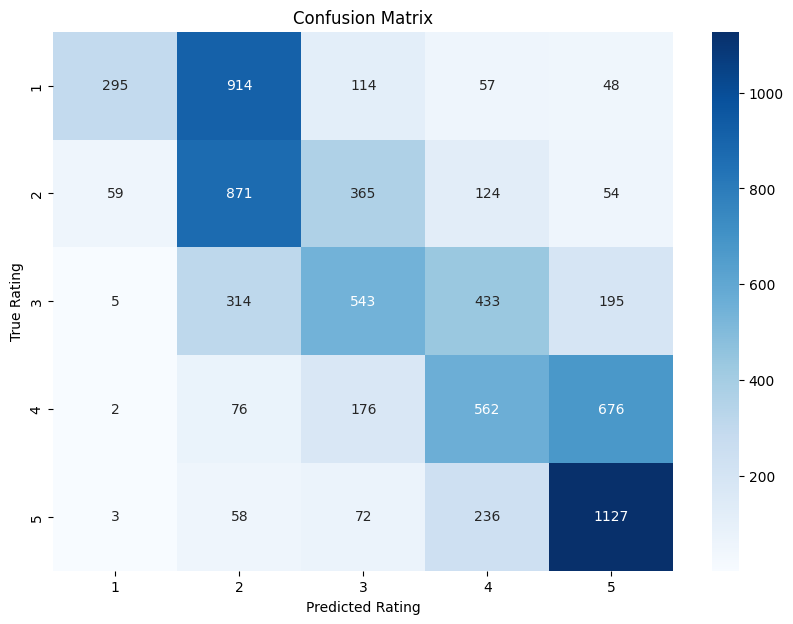

,precision,recall,f1-score,support
1,0.810440,0.206583,0.329241,1428.000000
2,0.390058,0.591310,0.470049,1473.000000
3,0.427559,0.364430,0.393478,1490.000000
4,0.398017,0.376676,0.387052,1492.000000
5,0.536667,0.753342,0.626808,1496.000000
accuracy,0.460496,0.460496,0.460496,0.460496
macro avg,0.512548,0.458468,0.441326,7379.000000
weighted avg,0.510316,0.460496,0.442337,7379.000000


In [4]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the predicted ratings
df_predicted = pd.read_csv('combined_predicted_ratings.csv')
df_predicted = df_predicted[(df_predicted["Real Rating"] != 0) & (df_predicted["Predicted Rating"] != 0)]

# Extract the real and predicted ratings
y_true = df_predicted['Real Rating']
y_pred = df_predicted['Predicted Rating'].astype(int)  # Ensure the predicted ratings are integers

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(1, 6)], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

#### With 0 rating

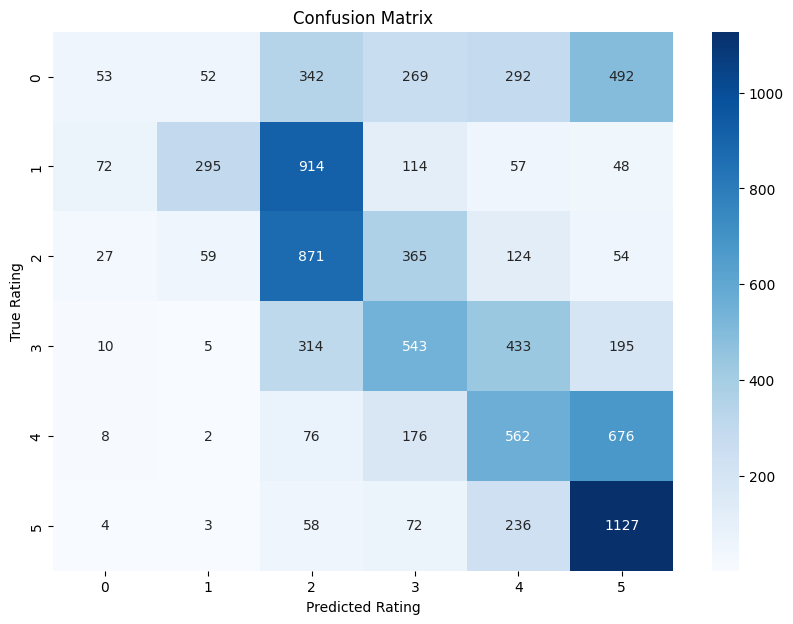

,precision,recall,f1-score,support
0,0.304598,0.035333,0.063321,1500.000000
1,0.709135,0.196667,0.307933,1500.000000
2,0.338252,0.580667,0.427485,1500.000000
3,0.352827,0.362000,0.357354,1500.000000
4,0.329812,0.374667,0.350811,1500.000000
5,0.434799,0.751333,0.550831,1500.000000
accuracy,0.383444,0.383444,0.383444,0.383444
macro avg,0.411570,0.383444,0.342956,9000.000000
weighted avg,0.411570,0.383444,0.342956,9000.000000


In [5]:
# Load the predicted ratings
df_predicted = pd.read_csv('combined_predicted_ratings.csv')

# Extract the real and predicted ratings
y_true = df_predicted['Real Rating']
y_pred = df_predicted['Predicted Rating'].astype(int)  # Ensure the predicted ratings are integers

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(0, 6)], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report